In [ ]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(0) 

# train on something else

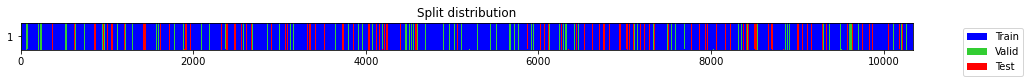

Counts by label: {'sinus rhythm': 1752, 'left ventricular hypertrophy': 1232, 't wave abnormal': 2306, 'lateral ischaemia': 903, 'sinus bradycardia': 1677, 'right bundle branch block': 542, 'atrial fibrillation': 570, 't wave inversion': 812, 'nonspecific st t abnormality': 1883, 'atrial flutter': 186, 'ventricular premature beats': 357, 'left axis deviation': 940, 'sinus tachycardia': 1261, 'incomplete right bundle branch block': 407, 'prolonged qt interval': 1391, 'anterior ischemia': 281, 'low qrs voltages': 374, 'premature atrial contraction': 639, 'left anterior fascicular block': 180, 'left atrial enlargement': 870, 'left bundle branch block': 231, 'bundle branch block': 116, '1st degree av block': 769, 'qwave abnormal': 464, 'sinus arrhythmia': 455, 'inferior ischaemia': 451, 'st elevation': 134, 'early repolarization': 140, 'nonspecific intraventricular conduction disorder': 203, 'st interval abnormal': 992}


In [4]:

def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_Ga"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 0.5 percent of the samples
y=y[y.columns[y.sum()>(0.01*y.shape[0])]]
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
# df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
# y = snomedConvert(y)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))


In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True),
              tfs.RandomShift(30),
              tfs.MulNoise(3),
              tfs.CutOutWhenTraining(),
              tfs.Scale(scale_factor=0.5)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,)
learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph(),opt_func = wrap_optimizer(torch.optim.Adam,weight_decay=1e-4))
learn.fit_one_cycle(100, lr_max=0.0018562679873326028)
learn.recorder.plot_metrics()

# now test on main dataset

In [1]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)
# get diseases that exist in more than 0.5 percent of the samples
y=y[y.columns[y.sum()>(0.01*y.shape[0])]]
splits = get_splits(y.to_numpy(), valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
# df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
# y = snomedConvert(y)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

NameError: name 'np' is not defined

In [8]:
y.to_numpy()

array([[ True, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [False,  True, False, ..., False, False, False]])

In [ ]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [TSStandardize(by_sample=True),
              tfs.RandomShift(30),
              tfs.MulNoise(3),
              tfs.CutOut(),
              tfs.Scale(scale_factor=0.5)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
# model = MiniRocketPlus(dls.vars, dls.c,2500)
# model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=10,)
PATH = Path('./models/inception_ga.pkl')
learn = load_learner(PATH, cpu=False)
model = nn.Sequential(learn.model,nn.Linear(38, 9))

learn = Learner(dls, model, metrics=metrics, cbs=ShowGraph())
learn.fit_one_cycle(100, lr_max=0.18562679873326028)
learn.recorder.plot_metrics()

In [131]:
# PATH = Path('./models/inception_multilabel_old.pkl')
# PATH.parent.mkdir(parents=True, exist_ok=True)
# learn.export(PATH)

# load and test model

In [55]:
import optuna
PATH = Path('./models/inception_best_0.842064619064331.pkl')
learn = load_learner(PATH, cpu=False)
study = optuna.load_study(study_name='inception_study', storage='sqlite:///inception_study.db')
bp = study.best_trial.params
bp

{'cut_out': False,
 'noise': 6.0,
 'norm_type': 'Normalize',
 'random_shift': 0.1,
 'scale': 0.30000000000000004}

In [57]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
                TSStandardize(by_sample=True),
#                 tfs.Normalize(),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOut(),
              tfs.Scale(scale_factor=0.15)
             ]
# batch_tfms

dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(splits[0],splits[2])) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

y_pred = (valid_preds>0)
y_test = valid_targets

print(classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3))

                              precision    recall  f1-score   support

         1st degree av block      0.877     0.814     0.844        70
         atrial fibrillation      0.932     0.948     0.940       116
    left bundle branch block      0.792     1.000     0.884        19
premature atrial contraction      0.658     0.417     0.510        60
   right bundle branch block      0.935     0.959     0.947       196
                sinus rhythm      0.625     0.747     0.681        87
               st depression      0.821     0.802     0.812        86
                st elevation      0.421     0.333     0.372        24
        ventricular ectopics      0.809     0.618     0.701        89

                   micro avg      0.827     0.798     0.812       747
                   macro avg      0.763     0.738     0.743       747
                weighted avg      0.823     0.798     0.805       747
                 samples avg      0.781     0.793     0.781       747

